<a href="https://colab.research.google.com/github/Siarzis/ai-tutor/blob/main/lfc_disturbance_prediction_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [27]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

Load and plot the training data

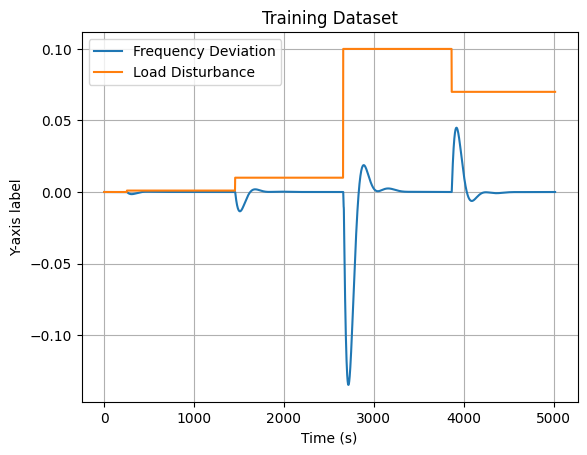

In [37]:
train_dataset_df = pd.read_csv('train_dataset.csv', dtype=np.float32)

plt.figure()
plt.plot(train_dataset_df.iloc[:, 1], label='Frequency Deviation')
plt.plot(train_dataset_df.iloc[:, 2], label='Load Disturbance')
plt.xlabel('Time (s)')
plt.ylabel('Y-axis label')
plt.title('Training Dataset')
plt.legend()
plt.grid(True)
plt.show()

Data preprocess

**Pipeline description**: csv format → data frame → numpy → tensor





In [32]:
def windowed_array(arr, window_size):
    # Calculate the number of subarrays
    num_windows = len(arr) - window_size + 1

    # Create an empty array to store the result
    result = np.empty((num_windows, window_size), dtype=arr.dtype)

    # Fill the result array with windowed slices
    for i in range(num_windows):
        result[i] = arr[i:i+window_size]

    return result

class CustomDataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = torch.tensor(inputs)
        self.outputs = torch.tensor(outputs)

    def __len__(self):
        return len(self.inputs)  # Assuming all arrays have the same length

    def __getitem__(self, index):
        sample = tuple((self.inputs[index], self.outputs[index]))
        return sample

In [ ]:
X_train = train_dataset_df.iloc[:, 1].to_numpy()
y_train = train_dataset_df.iloc[:, 2].to_numpy()

print(X_train.dtype)

# for now, keep historical_window equal to prediction_window
# if not equal, the consider padding method
historical_window = 10
prediction_window = 10

X_train = X_train[:len(X_train)-historical_window]
y_train = y_train[10:]

X_train = windowed_array(X_train, historical_window)
y_train = windowed_array(y_train, prediction_window)

train_tensor = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_tensor, batch_size=64, shuffle=True)

print(train_loader)

Definition & initilization of MLP

In [34]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

# define feedforward neural network architecture
input_size = historical_window
hidden_size = 100
output_size = prediction_window

# Check for GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create an instance of the neural network
net = MLP(input_size, hidden_size, output_size)
net = nn.DataParallel(net)
net = net.to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss() # for classification tasks logarithmic/cross-entropy loss function is mainly used
optimizer = optim.SGD(net.parameters(), lr=0.01)

Training of MLP

In [47]:
epochs = 100
training_loss = []

for e in range(epochs):

    total_batch_loss = 0.0
    average_batch_loss = 0.0

    # forward pass
    for i_batch, (timeseries_batch, label_batch) in enumerate(train_loader):

        timeseries_batch = timeseries_batch.to(device)
        label_batch = label_batch.to(device)

        # nullify gradients for every batch
        optimizer.zero_grad()

        output = net(timeseries_batch)

        # compute loss and store the total loss in each epoch
        loss = criterion(output, label_batch)
        total_batch_loss += loss.item()

        # backpropagation
        loss.backward() # propagate the loss backwards
        optimizer.step() # update weights

    average_batch_loss = total_batch_loss / len(train_loader)
    training_loss.append(average_batch_loss)

    print('Epoch [{}/{}], Loss: {:.4f}'.format(e+1, epochs, average_batch_loss))

Epoch [1/1000], Loss: 0.9868
Epoch [2/1000], Loss: 0.9922
Epoch [3/1000], Loss: 0.9811
Epoch [4/1000], Loss: 0.9929
Epoch [5/1000], Loss: 0.9794
Epoch [6/1000], Loss: 0.9904
Epoch [7/1000], Loss: 0.9768
Epoch [8/1000], Loss: 0.9821
Epoch [9/1000], Loss: 0.9872
Epoch [10/1000], Loss: 0.9789
Epoch [11/1000], Loss: 0.9833
Epoch [12/1000], Loss: 0.9925
Epoch [13/1000], Loss: 0.9815
Epoch [14/1000], Loss: 0.9802
Epoch [15/1000], Loss: 0.9911
Epoch [16/1000], Loss: 0.9864
Epoch [17/1000], Loss: 0.9899
Epoch [18/1000], Loss: 0.9859
Epoch [19/1000], Loss: 0.9895
Epoch [20/1000], Loss: 0.9899
Epoch [21/1000], Loss: 0.9851
Epoch [22/1000], Loss: 0.9891
Epoch [23/1000], Loss: 0.9881
Epoch [24/1000], Loss: 0.9819
Epoch [25/1000], Loss: 0.9828
Epoch [26/1000], Loss: 0.9850
Epoch [27/1000], Loss: 0.9846
Epoch [28/1000], Loss: 0.9846
Epoch [29/1000], Loss: 0.9802
Epoch [30/1000], Loss: 0.9916
Epoch [31/1000], Loss: 0.9899
Epoch [32/1000], Loss: 0.9938
Epoch [33/1000], Loss: 0.9929
Epoch [34/1000], Lo

KeyboardInterrupt: 

Plot training loss

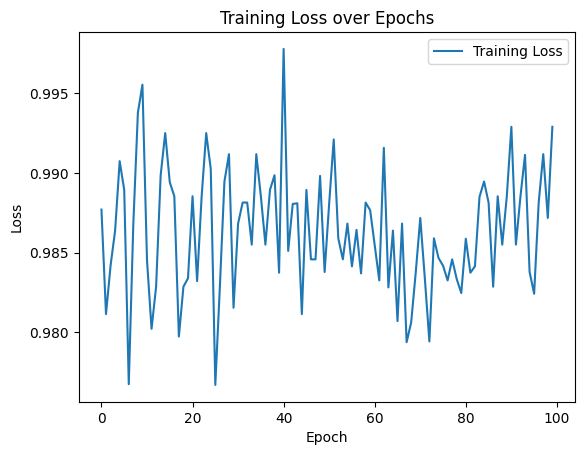

In [45]:
# Plot the training loss
plt.plot(training_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
num_points = 1000
seq_length = 10

sine_values = np.sin(np.linspace(0, 10*np.pi, num_points))
cosine_values = np.cos(np.linspace(0, 10*np.pi, num_points))

# Convert to PyTorch tensors
sine_tensor = torch.tensor(sine_values, dtype=torch.float32)
cosine_tensor = torch.tensor(cosine_values, dtype=torch.float32)

# Create sequences of sine values as input and corresponding cosine values as output
input_data = torch.stack([sine_tensor[i:i+seq_length] for i in range(num_points - seq_length)]).unsqueeze(2)
output_data = torch.stack([cosine_tensor[i+seq_length] for i in range(num_points - seq_length)]).unsqueeze(1)

print(input_data[0], output_data[0])

tensor([[0.0000],
        [0.0314],
        [0.0629],
        [0.0942],
        [0.1255],
        [0.1566],
        [0.1876],
        [0.2184],
        [0.2489],
        [0.2793]]) tensor([0.9510])
